<a href="https://colab.research.google.com/github/roa212003/CatsVsDogs_Classification/blob/main/CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting data up from Kaggle

In [ ]:
from IPython import get_ipython
from IPython.display import display

from google.colab import files
!pip install -q kaggle

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset --force

!unzip /content/microsoft-catsvsdogs-dataset.zip -d /content/dataset

Loading libraries

In [2]:
# Basic
import os
import shutil
from shutil import copyfile
import numpy as np
import pandas as pd
import tensorflow as tf
import random

# visuals
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

Eliminating the invalid images for further process

In [3]:
valid_images = [".jpg", ".jpeg", ".png"]

def remove_invalid_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith(tuple(valid_images)):
                print(f"Invalid file found and removed: {file_path}")
                os.remove(file_path)
            else:
                try:
                    # Try opening the image using PIL to verify its validity.
                    Image.open(file_path).verify()
                except (IOError, SyntaxError) as e:
                    print(f"Corrupted image found and removed: {file_path} - {e}")
                    os.remove(file_path)

#remove any invalid image files
remove_invalid_images("/content/dataset/PetImages/Dog")
remove_invalid_images("/content/dataset/PetImages/Cat")

Invalid file found and removed: /content/dataset/PetImages/Dog/Thumbs.db
Corrupted image found and removed: /content/dataset/PetImages/Dog/11702.jpg - cannot identify image file '/content/dataset/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Invalid file found and removed: /content/dataset/PetImages/Cat/Thumbs.db
Corrupted image found and removed: /content/dataset/PetImages/Cat/666.jpg - cannot identify image file '/content/dataset/PetImages/Cat/666.jpg'


Creating directories for training and validation

In [4]:
try:
    os.makedirs('/content/tmp/cats-and-dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training/cats', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation/cats', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test/cats', exist_ok = True)
except OSError:
    print("Failed to make directory")

Defining data path

In [5]:
dog_dir = '/content/dataset/PetImages/Dog'
cat_dir = '/content/dataset/PetImages/Cat'

training_dir =  '/content/tmp/cats-and-dogs/training'
validation_dir =  '/content/tmp/cats-and-dogs/validation'

training_cat = os.path.join(training_dir, 'cats/')
training_dog = os.path.join(training_dir, 'dogs/')

validation_cat = os.path.join(validation_dir, 'cats/')
validation_dog = os.path.join(validation_dir, 'dogs/')

Splitting data into training, validation and test data

In [6]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None,  split_size=0.8):
    files =  []
    for f in os.listdir(main_dir):
        if len(os.path.join(main_dir,f)):
            files.append(f)

    shuffled_files = random.sample(files, len(files))
    split_index = int(len(shuffled_files)*split_size)

    X_train = shuffled_files[:split_index]
    split_val_index = int(split_index+(1-split_size)*len(shuffled_files)/2)
    X_val = shuffled_files[split_index:split_val_index]
    X_test = shuffled_files[split_val_index:len(shuffled_files)]

    for element in X_train:
        copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))

    for element in X_val:
        copyfile(os.path.join(main_dir, element), os.path.join(validation_dir,element))

    for element in X_test:
        copyfile(os.path.join(main_dir, element), os.path.join(test_dir,element))
    print("Split successful!")

In [7]:
split_data(dog_dir, training_dog, validation_dog, '/content/tmp/cats-and-dogs/test/dogs', 0.8)
split_data(cat_dir, training_cat, validation_cat, '/content/tmp/cats-and-dogs/test/cats', 0.8)

Split successful!
Split successful!


Creating generators

In [41]:
train_datagen = ImageDataGenerator(     #Data augmentation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)
validation_gen =  ImageDataGenerator(rescale=1./255.)
test_gen =  ImageDataGenerator(rescale=1./255.)

In [42]:
training_generator = training_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary',
)

validation_generator = validation_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

test_generator = test_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/test',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


Visualizing the images to check if we get the correct data

In [32]:
class_names = ['Cat', 'Dog']
def visualize_images(generator, n_images=5):
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for i, (image, label) in enumerate(zip(images, labels), start=1):
        if i > n_images:
            break
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.axis('off')

        title_obj = plt.title(class_names[label])
        plt.setp(title_obj, color='b')

    plt.show()

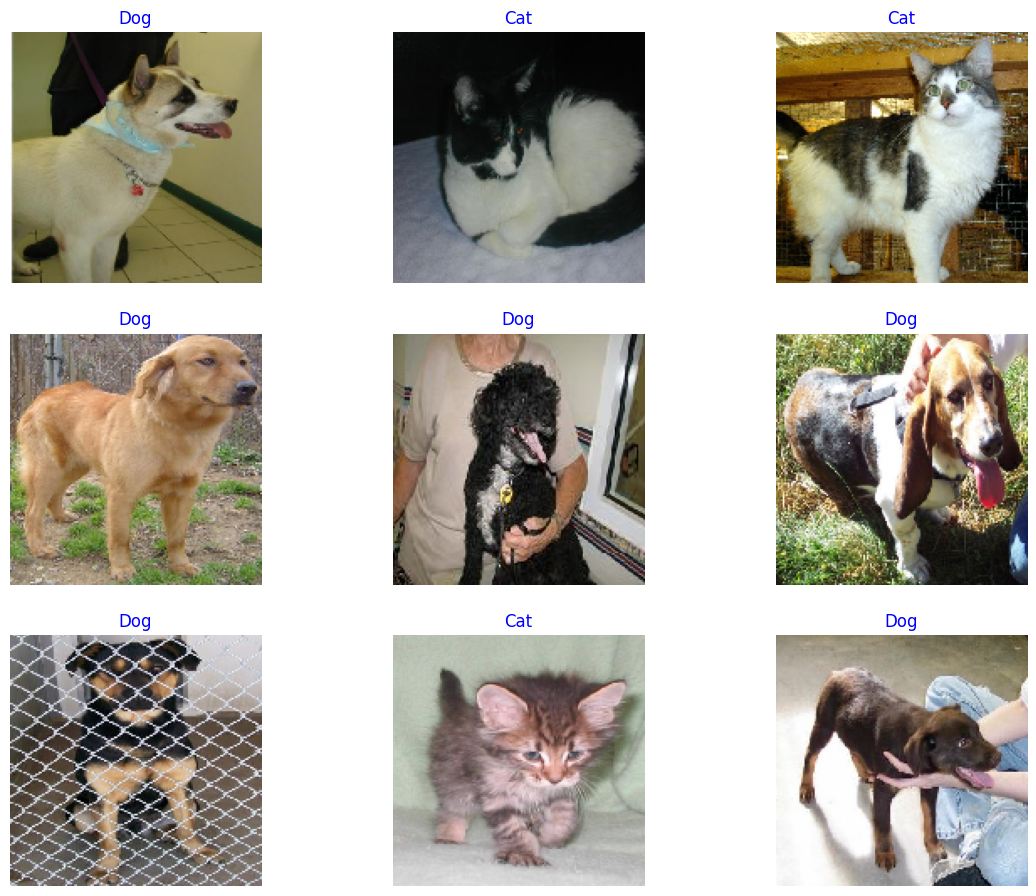

In [36]:
visualize_images(training_generator, 9)

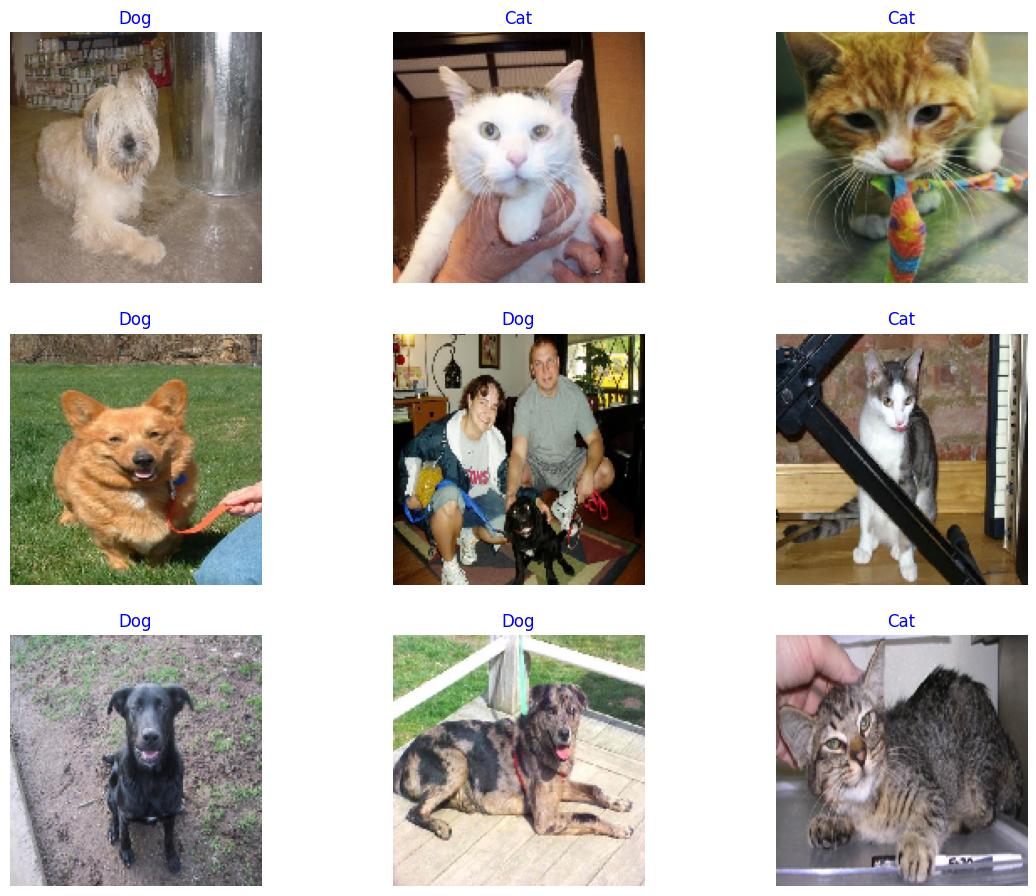

In [37]:
visualize_images(validation_generator, 9)

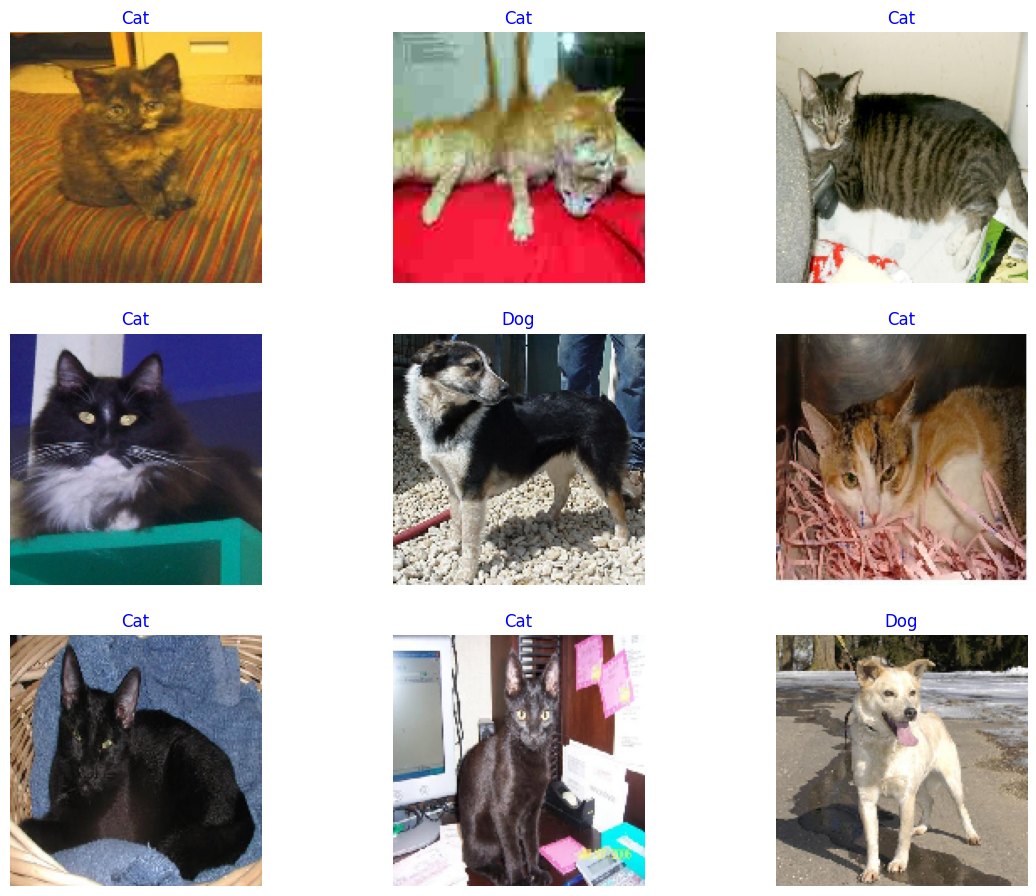

In [38]:
visualize_images(test_generator, 9)

Defining, Compiling and Training model

In [47]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))      #Avoid overfitting

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))      #Avoid overfitting

model.add(Flatten())

model.add(Dense(128, activation =  'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation =  'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation =  'relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 165888)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │      21,233,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,319,809 (81.33 MB)

 Trainable params: 21,319,809 (81.33 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [49]:
model_training = model.fit(
    training_generator,
    epochs=15,
    batch_size = 64,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.5251 - loss: 0.8179 - val_accuracy: 0.5689 - val_loss: 0.6848
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.6056 - loss: 0.6677 - val_accuracy: 0.6757 - val_loss: 0.6124
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.7014 - loss: 0.5840 - val_accuracy: 0.7066 - val_loss: 0.5641
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.7538 - loss: 0.5167 - val_accuracy: 0.7406 - val_loss: 0.5270
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.7924 - loss: 0.4521 - val_accuracy: 0.7666 - val_loss: 0.4940
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.8292 - loss: 0.3909 - val_accuracy: 0.7582 - val_loss: 0.5194
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.8517 - loss: 0.3385 - val_accuracy: 0.7622 - val_loss: 0.5379
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.8842 - loss: 0

Evaluating model

In [50]:
model.evaluate(test_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7768 - loss: 0.7850


[0.7247858643531799, 0.785371720790863]

Predicting some predictions

In [51]:
def plot_prediction(generator, n_images):
    images, labels = next(generator)
    labels = labels.astype('int32')

    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)

    plt.figure(figsize=(14, 15))
    for i, (image, label) in enumerate(zip(images, labels), start=1):
        if i > n_images:
            break

        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.axis('off')

        title_color = 'g' if predictions[i - 1] == label else 'r'
        title_obj = plt.title(class_names[label])
        plt.setp(title_obj, color=title_color)

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


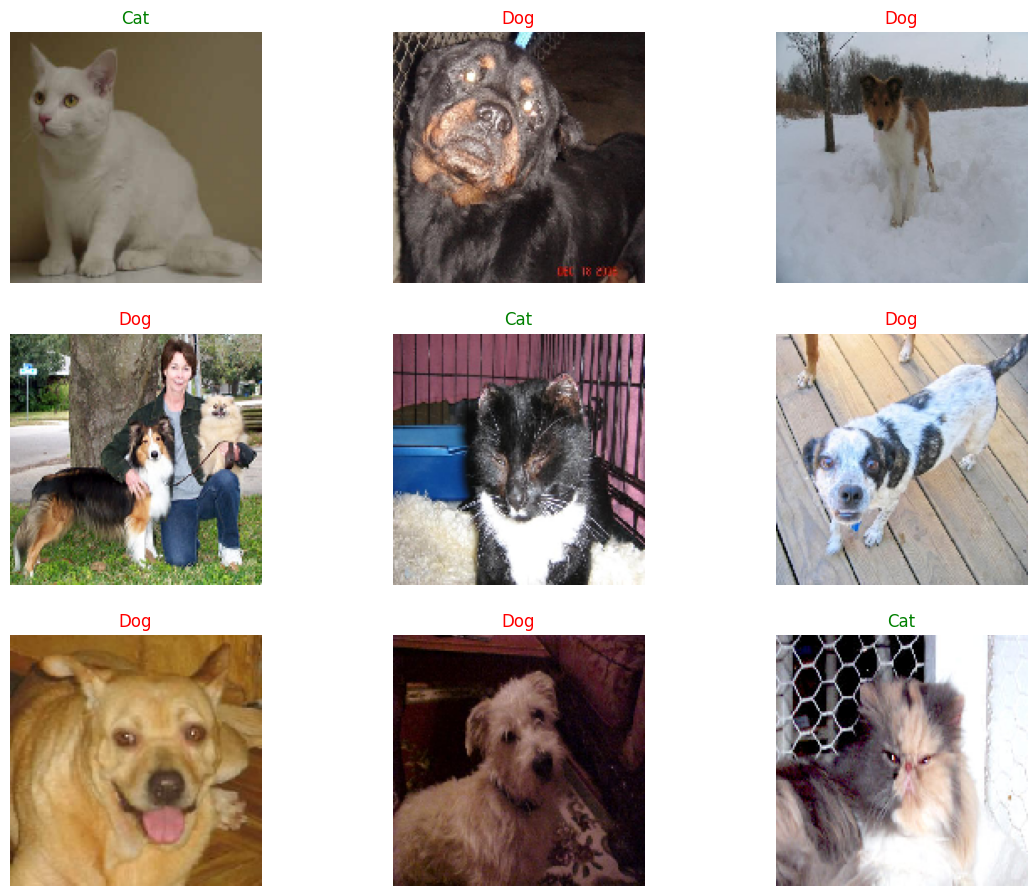

In [52]:
plot_prediction(validation_generator, 9)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


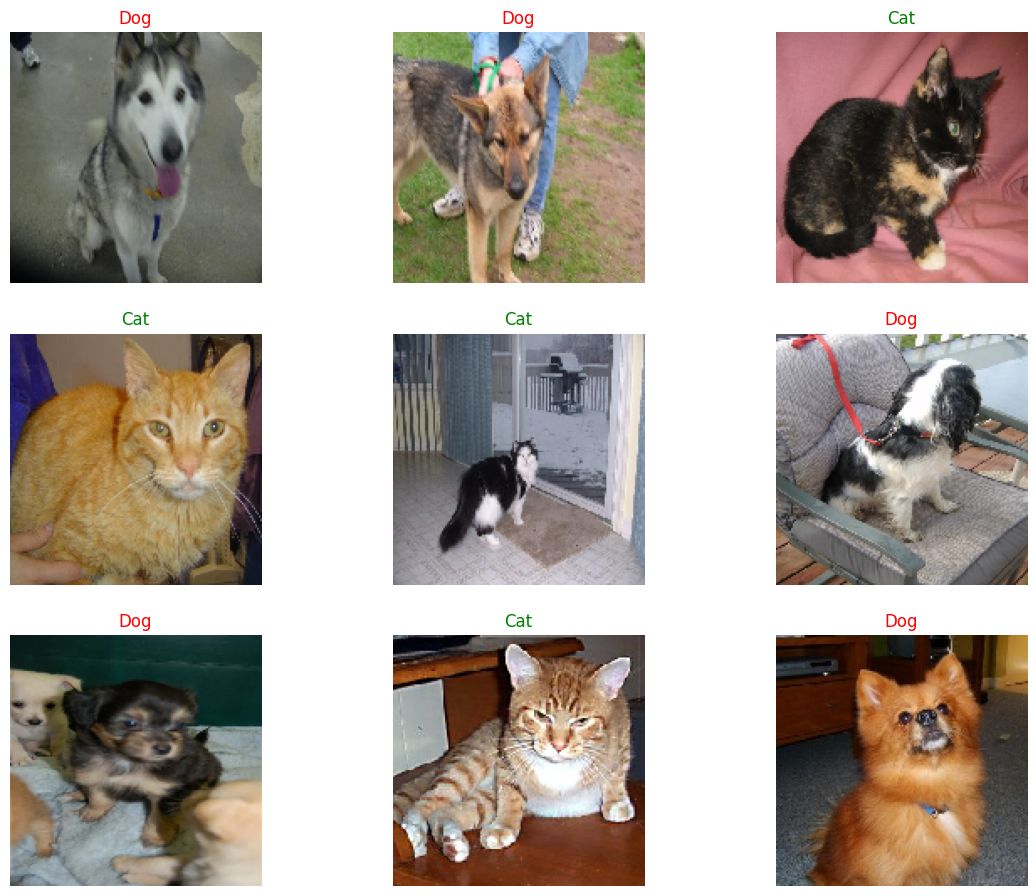

In [53]:
plot_prediction(test_generator, 9)